# Analyse du sondage sur la précarité

Grandes questions sur l'architecture du rapport:

- est-ce qu'on fait une description puis analyse des facteurs influence pour chaque type de précarité ou bien plutot une descritpion générale avec nos indicateurs de précarité puis pleins de sous-parties explicatives?

- est-ce qu'on essaye de créer un indicatif/score de précarité? Ça peut être interessant et facile à utiliser pour les analyses

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
import string
import json
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from sci_analysis import analyze
from scipy.stats import ttest_ind
import plotly.express as px


In [4]:
# Load the data

data = pd.read_csv("precarite.csv")
data.head()

,Horodateur,Score,De quel pays viens-tu (nationalité)?\n\nWhat is your country of origin (nationality)?,Quel est ton niveau d'études?\n\nWhat's your level of studies?,Quel est ton école?\n\nWhich school do you go to?,Quelle est ton expression de genre?\n\nWhat is your expression of genre?,Es-tu en échange à l'EPFL/ l'UNIL?\n\nAre you doing an exchange at EPFL/UNIL?,Combien as-tu d'enfants?\n\nHow many kids do you have?,"En moyenne, quelles sont tes dépenses mensuelles (en CHF) (en comptant logement, alimentation, loisir, santé, frais liés aux études)?\nApproximately, what are your monthly expenses (CHF) (taking into account housing, food, healthcare, hobbies and study fees)",Combien payes-tu ton loyer (CHF)? \n\nHow much is your rent? (CHF),...,Tes parents ont-ils fait des études supérieurs?\n\nDid your parents go to college/university?,Ta famille soutient-elle tes choix d'études / de carrière?\n\nDoes your family support you in your choice of studies/ of carrier?,Ta famille soutient-elle ton expression de genre/ ta sexualité?\n\nDoes your family support your expression of genre/ sexuality?,Ressens-tu une pression de réussite vis-à-vis de ta famille?\n\nDoes your family pressure you to succeed in your studies?,Vis-tu:\n\nDo you live:,"Si tu ne vis pas seul.e, quel type de relation entretiens-tu avec les personnes partageant ton logement?\n\nIf you don't live alone, how is the relationship with the people you live?",À quelle fréquence vois-tu des ami.es en dehors du contexte d'étude?\n\nHow often are you seeing your friends from school outside from lectures?,As-tu des ami.es avec qui tu peux travailler?\n\nDo you have friends you can work with?,"En cas de problème, as tu quelqu'un.e sur place sur qui tu peux compter? Pour discuter au téléphone, pour t'accompagner chez le docteur,...\nIn case of emergency, do you have someone close you can count on? Call to chat, go to the doctor with, ...",Est-ce que la sensation de solitude te pèse au quotidien?\n\nDoes the feeling of loneliness is part of your daily life?
0,10/04/2024 18:15:20,NaN,France,Master,EPFL,Woman,No,0.0,1700.0,900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/04/2024 18:18:58,NaN,France,Master,EPFL,Woman,No,0.0,1400.0,700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/04/2024 18:41:44,NaN,Benin,Master,EPFL,Woman,No,0.0,1700.0,807.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/04/2024 18:52:43,NaN,Switzerland,Bachelor,EPFL,Man,No,0.0,NaN,600.0,...,Oui (un seul ou les deux) - Yes (one or both),Oui - Yes,Oui - Yes,Oui - Yes,En colocation - In flatsharing,3.0,Plusieurs fois par mois - Several times a month,Oui - Yes,Oui - Yes,Non - No
4,10/04/2024 18:59:28,NaN,France,Master,EPFL,Woman,Yes,0.0,1500.0,900.0,...,Oui (un seul ou les deux) - Yes (one or both),Oui - Yes,Oui - Yes,Oui - Yes,En colocation - In flatsharing,5.0,Plusieurs fois par semaine - Several times a week,Oui - Yes,Oui - Yes,Oui parfois - Yes sometimes


In [5]:
#Drop 2 premières colonnes
data.drop(columns=['Horodateur','Score'], inplace=True)


In [6]:
# Renommer les colonnes
data.columns=['Nationalité','Études','École','Genre','Échange','Enfants','Dépenses','Loyer','Revenus','Travail','Salaire','2bou','Bourses','Budget alimentaire','Manger bien et assez','Mealprep','Épiceries solidaires','Dépenser +','Ramen','Pk raviolis','OALC!','Assurance','Maladie','Médecin','Sport','Point santé','Pharmacie','Menstruations','Santé mentale','Avenir','Diagnostic','Dispositif aides','Famille','Études parents','Soutien familiale études','Soutien familiale genre','Pression réussite','Logement','Relation coloc','Freq pote','Work buddies','Amis ambulance','Solitude']
data.head()

,Nationalité,Études,École,Genre,Échange,Enfants,Dépenses,Loyer,Revenus,Travail,...,Études parents,Soutien familiale études,Soutien familiale genre,Pression réussite,Logement,Relation coloc,Freq pote,Work buddies,Amis ambulance,Solitude
0,France,Master,EPFL,Woman,No,0.0,1700.0,900.0,"Famille - Family, Bourse",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,France,Master,EPFL,Woman,No,0.0,1400.0,700.0,"Bourses internationales (ERASMUS, CROUS) - Int...",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Benin,Master,EPFL,Woman,No,0.0,1700.0,807.0,Famille - Family,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Switzerland,Bachelor,EPFL,Man,No,0.0,NaN,600.0,Famille - Family,2.0,...,Oui (un seul ou les deux) - Yes (one or both),Oui - Yes,Oui - Yes,Oui - Yes,En colocation - In flatsharing,3.0,Plusieurs fois par mois - Several times a month,Oui - Yes,Oui - Yes,Non - No
4,France,Master,EPFL,Woman,Yes,0.0,1500.0,900.0,"Salaire - Salary, Famille - Family",2.0,...,Oui (un seul ou les deux) - Yes (one or both),Oui - Yes,Oui - Yes,Oui - Yes,En colocation - In flatsharing,5.0,Plusieurs fois par semaine - Several times a week,Oui - Yes,Oui - Yes,Oui parfois - Yes sometimes


In [7]:
# Convertir les colonnes chiffre en numeric

data['Enfants']=pd.to_numeric(data['Enfants'])
data['Dépenses']=pd.to_numeric(data['Dépenses'])
data['Loyer']=pd.to_numeric(data['Loyer'])
data['Travail']=pd.to_numeric(data['Travail'])
data['Salaire']=pd.to_numeric(data['Salaire'])
data['Budget alimentaire']=pd.to_numeric(data['Budget alimentaire'])
data['Mealprep']=pd.to_numeric(data['Mealprep'])
data['Relation coloc']=pd.to_numeric(data['Relation coloc'])
data['Enfants']=pd.to_numeric(data['Enfants'])


In [8]:
#Colonnes à choix multiples: Revenus, santé mentale, pk ramen, sport

#Revenus

Famille=[]
Bourses_EPFL=[]
Bourses_canton=[]
Bourses_internat=[]
Travail=[]
Pret=[]

T=data['Revenus'].str.contains('Salaire')
for i in data.index:
    if T[i]==True:
        Travail.append(1)
    else:
        Travail.append(0)

data['Revenus_travail']=Travail


BE=data['Revenus'].str.contains('Bourses UNIL')
for i in data.index:
    if BE[i]==True:
        Bourses_EPFL.append(1)
    else:
        Bourses_EPFL.append(0)

data['Revenus_bourses_EPFL_UNIL']=Bourses_EPFL


BC=data['Revenus'].str.contains('Bourses cantonales')
for i in data.index:
    if BC[i]==True:
        Bourses_canton.append(1)
    else:
        Bourses_canton.append(0)

data['Revenus_bourses_canton']=Bourses_EPFL

BI=data['Revenus'].str.contains('Bourses internationales')
for i in data.index:
    if BI[i]==True:
        Bourses_internat.append(1)
    else:
        Bourses_internat.append(0)

data['Revenus_bourses_internationales']=Bourses_internat

F=data['Revenus'].str.contains('Famille')
for i in data.index:
    if F[i]==True:
        Famille.append(1)
    else:
        Famille.append(0)

data['Revenus_famille']=Famille


P=data['Revenus'].str.contains('Emprunt')
for i in data.index:
    if P[i]==True:
        Pret.append(1)
    else:
        Pret.append(0)

data['Revenus_emprunt']=Pret



In [9]:
#Santé mentale

Heureux=[]
Satisfait=[]
Neutre=[]
Triste=[]
Angry=[]
Stressed=[]
Anxieux=[]
Depressed=[]

H=data['Santé mentale'].str.contains('Heureux')
for i in data.index:
    if H[i]==True:
        Heureux.append(1)
    else:
        Heureux.append(0)

data['SM_heureux']=Heureux

S=data['Santé mentale'].str.contains('Satisfait')
for i in data.index:
    if S[i]==True:
        Satisfait.append(1)
    else:
        Satisfait.append(0)

data['SM_satisfait']=Satisfait

N=data['Santé mentale'].str.contains('Neutre')
for i in data.index:
    if N[i]==True:
        Neutre.append(1)
    else:
        Neutre.append(0)

data['SM_neutre']=Neutre

T=data['Santé mentale'].str.contains('Triste')
for i in data.index:
    if T[i]==True:
        Triste.append(1)
    else:
        Triste.append(0)

data['SM_triste']=Triste

St=data['Santé mentale'].str.contains('Stressé')
for i in data.index:
    if St[i]==True:
        Stressed.append(1)
    else:
        Stressed.append(0)

data['SM_stressé']=Stressed

Anx=data['Santé mentale'].str.contains('Anxieux')
for i in data.index:
    if Anx[i]==True:
        Anxieux.append(1)
    else:
        Anxieux.append(0)

data['SM_anxieux']=Anxieux

Dp=data['Santé mentale'].str.contains('Déprimé')
for i in data.index:
    if Dp[i]==True:
        Depressed.append(1)
    else:
        Depressed.append(0)

data['SM_déprimé']=Depressed


In [10]:
#Pk raviolis

Envie=[]
Temps=[]
Argent=[]
Flemme=[]
Cuisiner=[]

Env=data['Pk raviolis'].str.contains('envie')
for i in data.index:
    if Env[i]==True:
        Envie.append(1)
    else:
        Envie.append(0)

data['PK_ravioli_envie']=Envie

Te=data['Pk raviolis'].str.contains('temps')
for i in data.index:
    if Te[i]==True:
        Temps.append(1)
    else:
        Temps.append(0)

data['PK_ravioli_temps']=Temps

Arg=data['Pk raviolis'].str.contains('argent')
for i in data.index:
    if Arg[i]==True:
        Argent.append(1)
    else:
        Argent.append(0)

data['PK_ravioli_argent']=Argent

Fle=data['Pk raviolis'].str.contains('flemme')
for i in data.index:
    if Fle[i]==True:
        Flemme.append(1)
    else:
        Flemme.append(0)

data['PK_ravioli_flemme']=Flemme

Cui=data['Pk raviolis'].str.contains('cuisiner')
for i in data.index:
    if Cui[i]==True:
        Cuisiner.append(1)
    else:
        Cuisiner.append(0)

data['PK_ravioli_cuisiner']=Cuisiner



In [11]:
#Sport

Gratuit=[]
Payant=[]
Pas_envie=[]
Pas_les_sous=[]
Pas_le_temps=[]
Pb_physique=[]

Grat=data['Sport'].str.contains('gratuitement')
for i in data.index:
    if Grat[i]==True:
        Gratuit.append(1)
    else:
        Gratuit.append(0)
data['Sport_gratuit']=Gratuit

Pay=data['Sport'].str.contains('budget')
for i in data.index:
    if Pay[i]==True:
        Payant.append(1)
    else:
        Payant.append(0)
data['Sport_payant']=Payant

PasE=data['Sport'].str.contains('envie')
for i in data.index:
    if PasE[i]==True:
        Pas_envie.append(1)
    else:
        Pas_envie.append(0)
data['Sport_pas_envie']=Pas_envie

PasS=data['Sport'].str.contains('financi')
for i in data.index:
    if PasS[i]==True:
        Pas_les_sous.append(1)
    else:
        Pas_les_sous.append(0)
data['Sport_pas_sous']=Pas_les_sous

PasT=data['Sport'].str.contains('temps')
for i in data.index:
    if PasT[i]==True:
        Pas_le_temps.append(1)
    else:
        Pas_le_temps.append(0)
data['Sport_pas_temps']=Pas_le_temps

PasP=data['Sport'].str.contains('physique')
for i in data.index:
    if PasP[i]==True:
        Pb_physique.append(1)
    else:
        Pb_physique.append(0)
data['Sport_pb_physique']=Pb_physique



In [12]:
data.head()

,Nationalité,Études,École,Genre,Échange,Enfants,Dépenses,Loyer,Revenus,Travail,...,PK_ravioli_temps,PK_ravioli_argent,PK_ravioli_flemme,PK_ravioli_cuisiner,Sport_gratuit,Sport_payant,Sport_pas_envie,Sport_pas_sous,Sport_pas_temps,Sport_pb_physique
0,France,Master,EPFL,Woman,No,0.0,1700.0,900.0,"Famille - Family, Bourse",0.0,...,0,0,0,0,0,1,0,0,0,0
1,France,Master,EPFL,Woman,No,0.0,1400.0,700.0,"Bourses internationales (ERASMUS, CROUS) - Int...",0.0,...,1,0,1,0,0,1,0,0,0,0
2,Benin,Master,EPFL,Woman,No,0.0,1700.0,807.0,Famille - Family,0.0,...,0,0,0,0,0,1,0,0,0,0
3,Switzerland,Bachelor,EPFL,Man,No,0.0,NaN,600.0,Famille - Family,2.0,...,1,0,1,0,0,1,0,0,0,0
4,France,Master,EPFL,Woman,Yes,0.0,1500.0,900.0,"Salaire - Salary, Famille - Family",2.0,...,1,0,1,0,0,1,0,0,0,0


## 1 - Faire l'état des lieux descriptifs

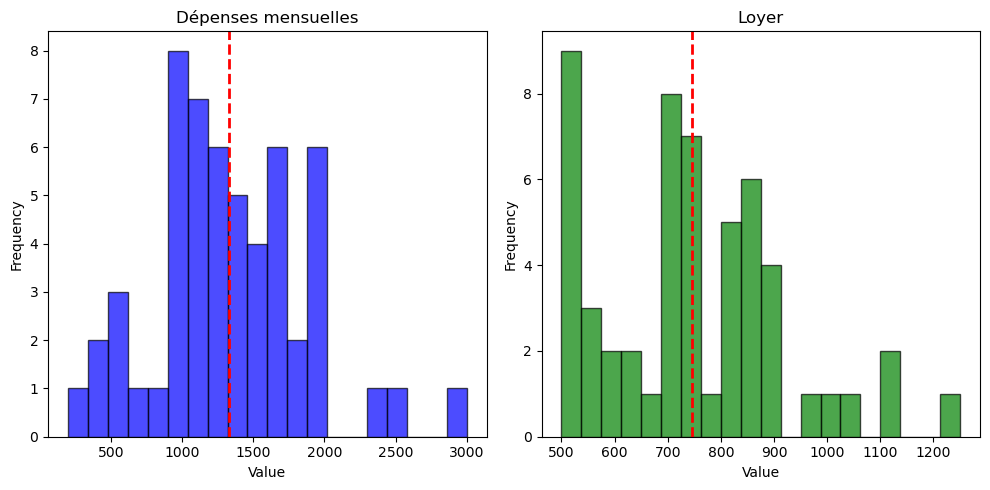

In [13]:
# Histogrammes des dépenses mensuelles et des prix des loyers

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram and mean line for panel 1
axs[0].hist(data['Dépenses'], bins=20, alpha=0.7, color='blue', edgecolor='black')
mean1 = np.mean(data['Dépenses'])
axs[0].axvline(mean1, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('Dépenses mensuelles')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot histogram and mean line for panel 2
axs[1].hist(data['Loyer'][data['Loyer']!=0], bins=20, alpha=0.7, color='green', edgecolor='black')
mean2 = np.mean(data['Loyer'][data['Loyer']!=0])
axs[1].axvline(mean2, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('Loyer')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

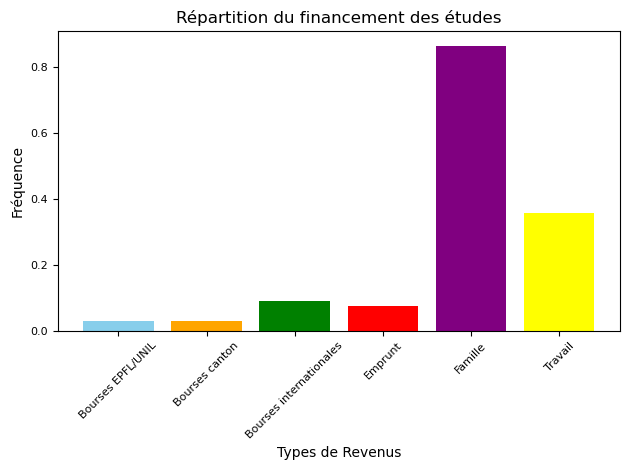

In [14]:
# Histogramme des sources de revenus

Types_Rev=['Revenus_bourses_EPFL_UNIL','Revenus_bourses_canton','Revenus_bourses_internationales','Revenus_emprunt','Revenus_famille','Revenus_travail']
Rev=[sum(data['Revenus_bourses_EPFL_UNIL'])/len(data),sum(data['Revenus_bourses_canton'])/len(data),
sum(data['Revenus_bourses_internationales'])/len(data),sum(data['Revenus_emprunt'])/len(data),
sum(data['Revenus_famille'])/len(data),sum(data['Revenus_travail'])/len(data)]

plt.bar(Types_Rev,Rev,color=['skyblue', 'orange', 'green', 'red', 'purple','yellow'])


plt.xlabel('Types de Revenus')
plt.ylabel('Fréquence')
plt.title('Répartition du financement des études')

# Change tick names
plt.xticks(Types_Rev, ['Bourses EPFL/UNIL','Bourses canton' ,'Bourses internationales', 'Emprunt', 'Famille', 'Travail'], rotation=45)

# Adjust tick label font size
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()



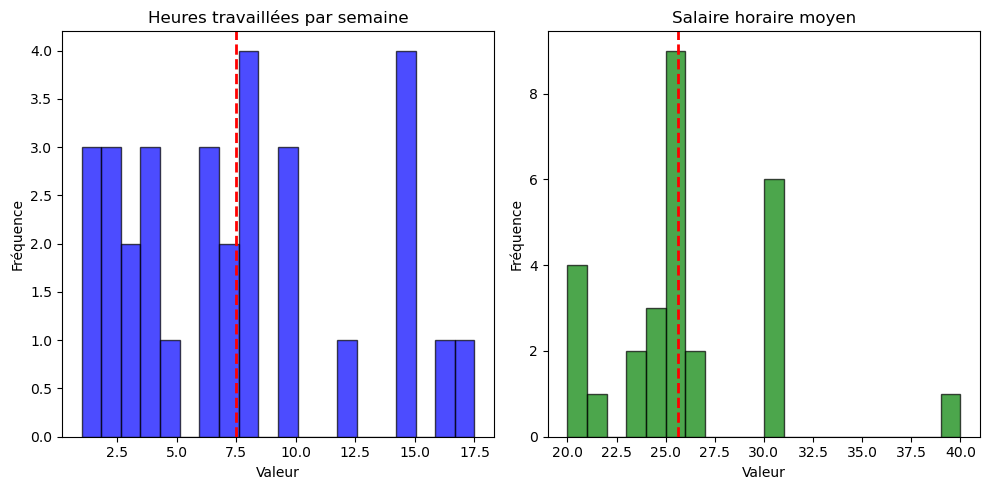

In [15]:
# Heures par semaines travaillées et salaire horaire moyen

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram and mean line for panel 1
axs[0].hist(data['Travail'][data['Travail']>0], bins=20, alpha=0.7, color='blue', edgecolor='black')
mean1 = np.mean(data['Travail'][data['Travail']>0])
axs[0].axvline(mean1, color='red', linestyle='dashed', linewidth=2)
axs[0].set_title('Heures travaillées par semaine')
axs[0].set_xlabel('Valeur')
axs[0].set_ylabel('Fréquence')

# Plot histogram and mean line for panel 2
axs[1].hist(data['Salaire'][(data['Salaire']<200) & (data['Salaire']>0)], bins=20, alpha=0.7, color='green', edgecolor='black')
mean2 = np.mean(data['Salaire'][(data['Salaire']<200) & (data['Salaire']>0)])
axs[1].axvline(mean2, color='red', linestyle='dashed', linewidth=2)
axs[1].set_title('Salaire horaire moyen')
axs[1].set_xlabel('Valeur')
axs[1].set_ylabel('Fréquence')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [16]:
# Pourcentage d'étudiants qui travaillent?

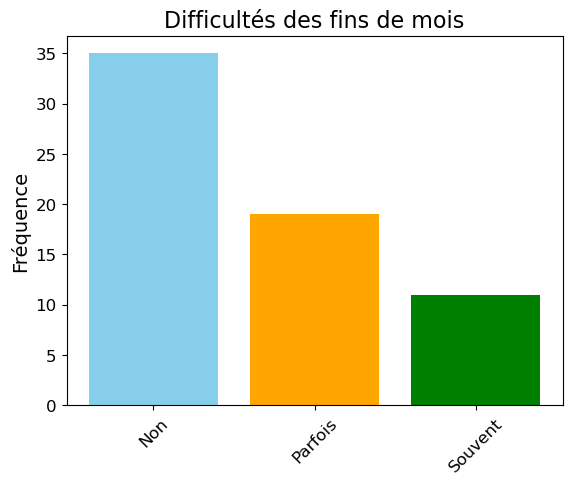

In [17]:
# Fins de mois difficiles

# Calculate frequency of each category
category_counts = data['2bou'].value_counts()


# Extract categories and their frequencies
Types_Rev = category_counts.index
Rev = category_counts.values

# Create bar plot
plt.bar(Types_Rev, Rev, color=['skyblue', 'orange', 'green', 'red', 'purple'])

# Add labels and title with adjusted font size
plt.ylabel('Fréquence', fontsize=14)
plt.title('Difficultés des fins de mois', fontsize=16)

# Change tick names
plt.xticks(Types_Rev, ['Non', 'Parfois', 'Souvent'], rotation=45)

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

# Alimentaire

Text(0, 0.5, 'Fréquence')

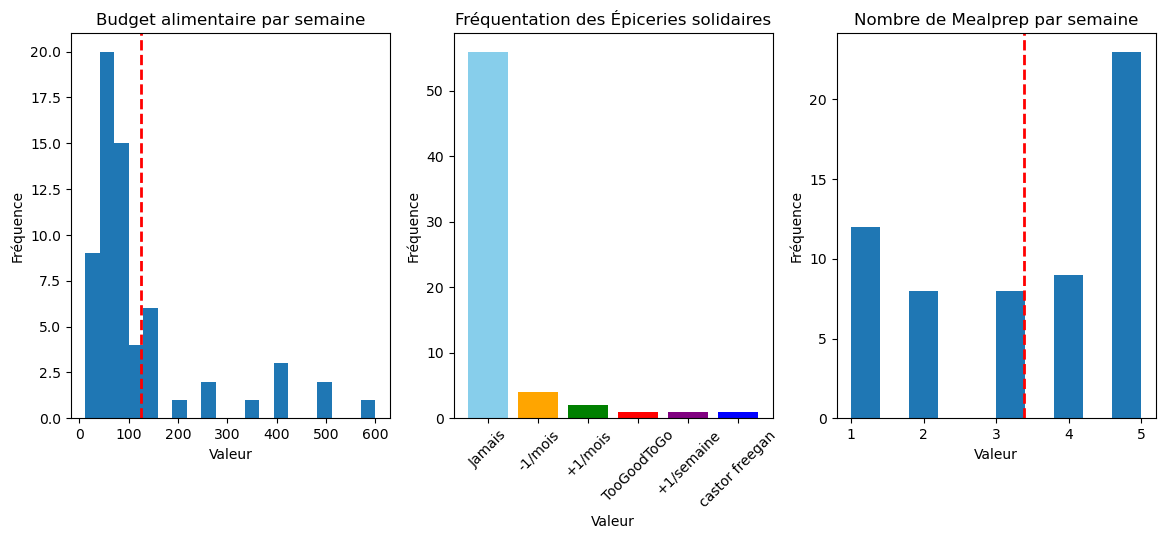

In [18]:
# budget alimentaire (en proportion par rapport au budget), mealprep, épiceries solidaires

fig, axs = plt.subplots(1, 3, figsize=(14, 5))



axs[0].hist(data['Budget alimentaire'][data['Budget alimentaire']>0], bins=20)
mean1 = np.mean(data['Budget alimentaire'][data['Budget alimentaire']>0])
axs[0].axvline(mean1, color='red', linestyle='dashed', linewidth=2)

axs[0].set_title('Budget alimentaire par semaine')
axs[0].set_xlabel('Valeur')
axs[0].set_ylabel('Fréquence')

# Calculate frequency of each category
category_counts = data['Épiceries solidaires'].value_counts()


# Extract categories and their frequencies
Types_Rev = category_counts.index
Rev = category_counts.values
axs[1].bar(['Jamais','-1/mois','+1/mois','TooGoodToGo','+1/semaine','castor freegan'], Rev, color=['skyblue', 'orange', 'green', 'red', 'purple','blue'])
axs[1].tick_params(axis='x', rotation=45)

axs[1].set_title('Fréquentation des Épiceries solidaires')
axs[1].set_xlabel('Valeur')
axs[1].set_ylabel('Fréquence')

axs[2].hist(data['Mealprep'])
mean2 = np.mean(data['Mealprep'])
axs[2].axvline(mean2, color='red', linestyle='dashed', linewidth=2)

axs[2].set_title('Nombre de Mealprep par semaine')
axs[2].set_xlabel('Valeur')
axs[2].set_ylabel('Fréquence')

Text(0, 0.5, 'Fréquence')

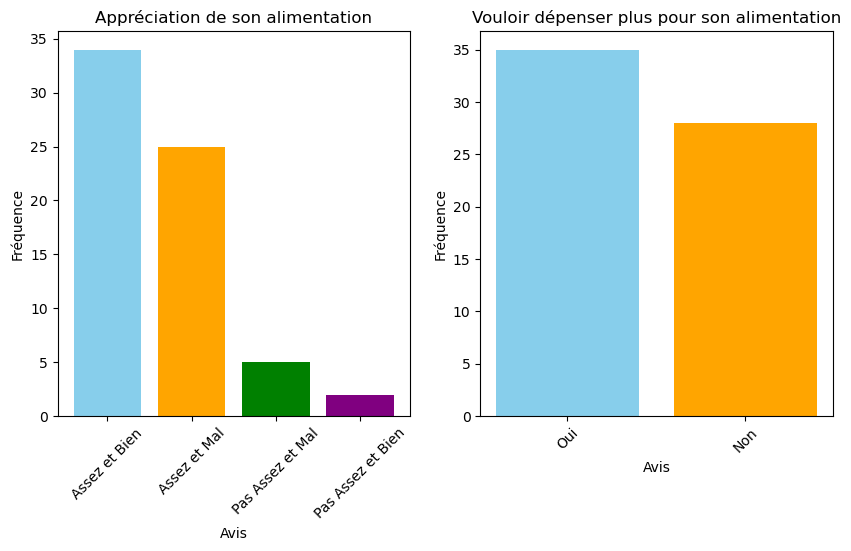

In [19]:
# manger bien et assez - dépenser +

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

category_counts = data['Manger bien et assez'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
axs[0].bar(['Assez et Bien','Assez et Mal','Pas Assez et Mal','Pas Assez et Bien'], Rev, color=['skyblue', 'orange', 'green', 'purple'])
axs[0].tick_params(axis='x', rotation=45)

axs[0].set_title('Appréciation de son alimentation')
axs[0].set_xlabel('Avis')
axs[0].set_ylabel('Fréquence')


category_counts = data['Dépenser +'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
axs[1].bar(['Oui','Non'], Rev, color=['skyblue', 'orange'])
axs[1].tick_params(axis='x', rotation=45)

axs[1].set_title('Vouloir dépenser plus pour son alimentation')
axs[1].set_xlabel('Avis')
axs[1].set_ylabel('Fréquence')


Text(0, 0.5, 'Fréquence')

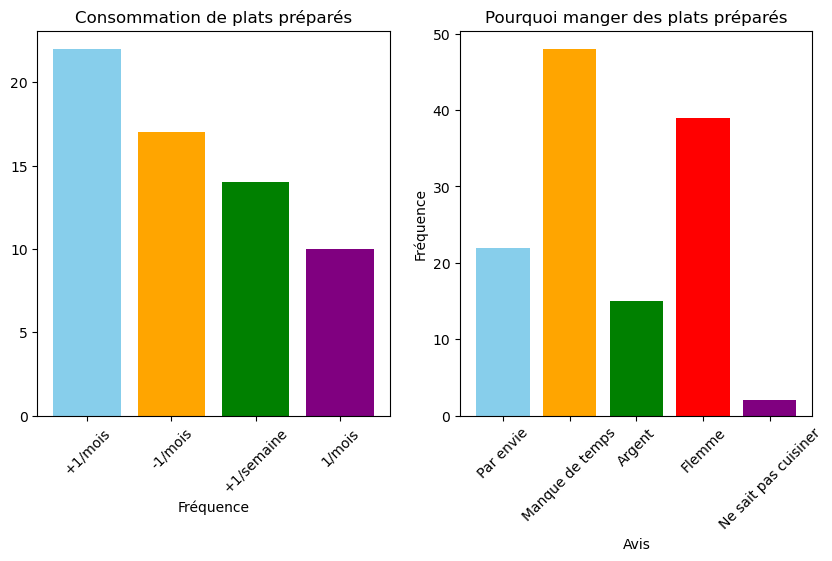

In [20]:
# plat préparés et pourquoi?

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


category_counts = data['Ramen'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
axs[0].bar(['+1/mois','-1/mois','+1/semaine','1/mois'], Rev, color=['skyblue', 'orange', 'green', 'purple'])
axs[0].tick_params(axis='x', rotation=45)

axs[0].set_title('Consommation de plats préparés')
axs[0].set_xlabel('Fréquence')


axs[1].bar(['Par envie','Manque de temps','Argent','Flemme','Ne sait pas cuisiner'],
           [sum(data['PK_ravioli_envie']),sum(data['PK_ravioli_temps']),sum(data['PK_ravioli_argent']),
            sum(data['PK_ravioli_flemme']),sum(data['PK_ravioli_cuisiner'])],
            color=['skyblue', 'orange', 'green', 'red', 'purple'])

axs[1].tick_params(axis='x', rotation=45)

axs[1].set_title('Vouloir dépenser plus pour son alimentation')
axs[1].set_xlabel('Avis')
axs[1].set_ylabel('Fréquence')

axs[1].tick_params(axis='x', rotation=45)

axs[1].set_title('Pourquoi manger des plats préparés')
axs[1].set_xlabel('Avis')
axs[1].set_ylabel('Fréquence')


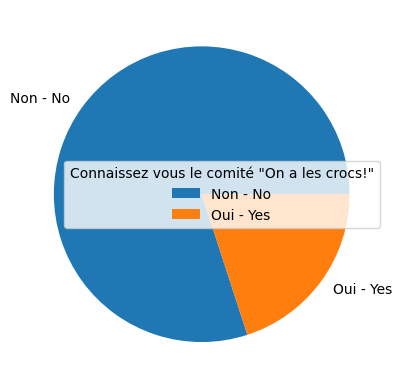

In [21]:
# on a les crocs

category_counts = data['OALC!'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values


plt.pie(Rev,labels=Types_Rev)
plt.legend(title='Connaissez vous le comité "On a les crocs!"')


# Santé

Text(0.5, 1.0, 'Comment êtes-vous assurés?')

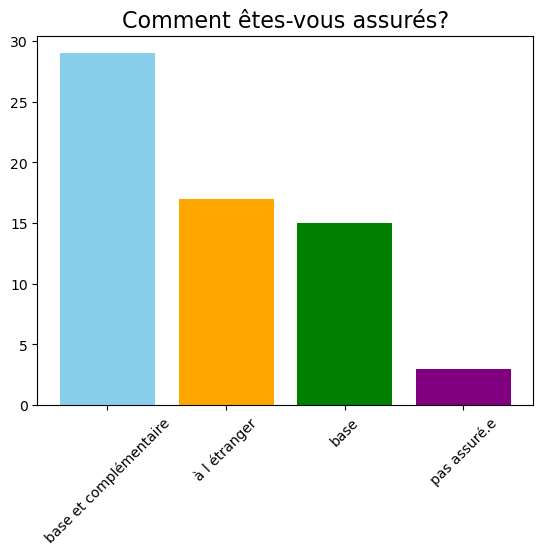

In [22]:
# assurance
data['Assurance']

category_counts = data['Assurance'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
plt.bar(['base et complémentaire','à l étranger','base','pas assuré.e'], Rev, color=['skyblue', 'orange', 'green', 'purple'])
plt.tick_params(axis='x', rotation=45)

plt.title('Comment êtes-vous assurés?', fontsize=16)


In [23]:
category_counts = data['Maladie'].value_counts()
Types_Rev = category_counts.index
Types_Rev

Index(['Oui, une fois depuis le début de l'année scolaire - Yes, once since the beginning of the school year',
       'Non, je ne suis pas tombé.e.x malade cette année - No, I did not get sick this year',
       'Oui, moins d'une fois par mois - Yes, less than once a month',
       'Oui, tous les mois - Yes, every month'],
      dtype='object', name='Maladie')

Text(0, 0.5, 'Fréquence')

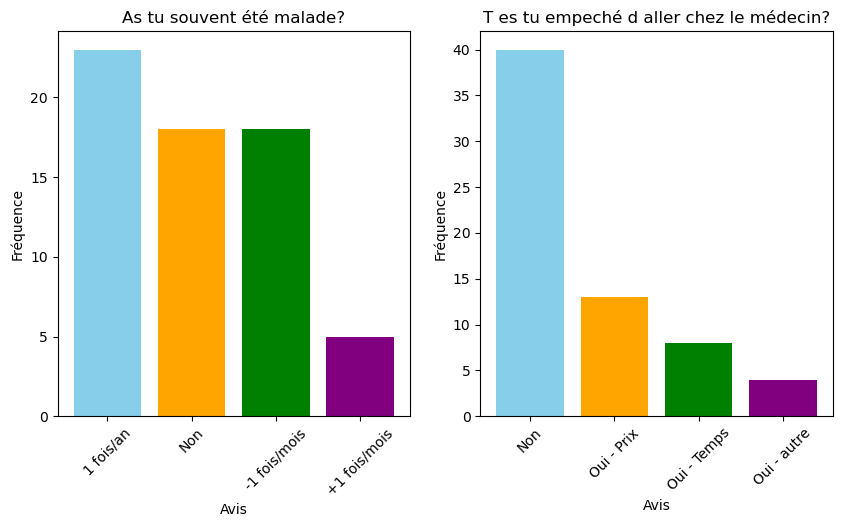

In [24]:
# maladie et médecin


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

category_counts = data['Maladie'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
axs[0].bar(['1 fois/an','Non','-1 fois/mois','+1 fois/mois'], Rev, color=['skyblue', 'orange', 'green', 'purple'])
axs[0].tick_params(axis='x', rotation=45)

axs[0].set_title('As tu souvent été malade?')
axs[0].set_xlabel('Avis')
axs[0].set_ylabel('Fréquence')



category_counts = data['Médecin'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
axs[1].bar(['Non','Oui - Prix','Oui - Temps','Oui - autre'], Rev, color=['skyblue', 'orange', 'green', 'purple'])
axs[1].tick_params(axis='x', rotation=45)

axs[1].set_title('T es tu empeché d aller chez le médecin?')
axs[1].set_xlabel('Avis')
axs[1].set_ylabel('Fréquence')



In [25]:
# sport



Text(0, 0.5, 'Fréquence')

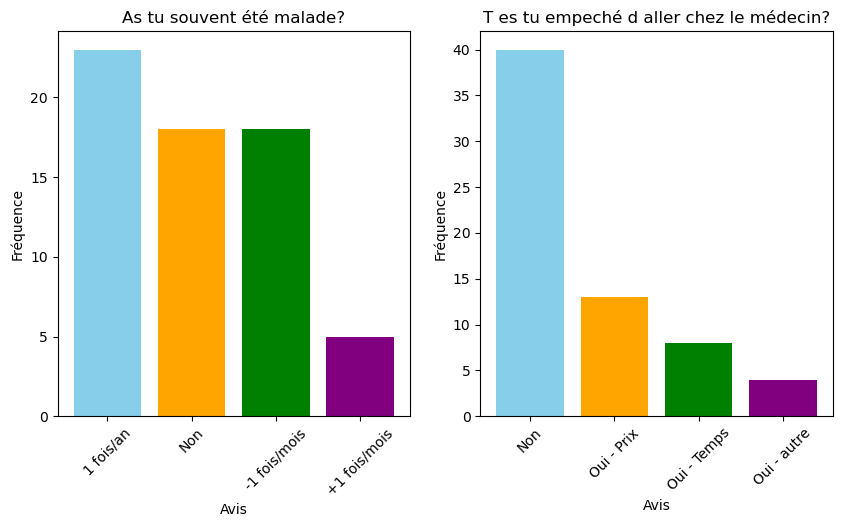

In [26]:
# point santé, pharmacie, menstruations

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

category_counts = data['Maladie'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
axs[0].bar(['1 fois/an','Non','-1 fois/mois','+1 fois/mois'], Rev, color=['skyblue', 'orange', 'green', 'purple'])
axs[0].tick_params(axis='x', rotation=45)

axs[0].set_title('As tu souvent été malade?')
axs[0].set_xlabel('Avis')
axs[0].set_ylabel('Fréquence')



category_counts = data['Médecin'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
axs[1].bar(['Non','Oui - Prix','Oui - Temps','Oui - autre'], Rev, color=['skyblue', 'orange', 'green', 'purple'])
axs[1].tick_params(axis='x', rotation=45)

axs[1].set_title('T es tu empeché d aller chez le médecin?')
axs[1].set_xlabel('Avis')
axs[1].set_ylabel('Fréquence')

In [27]:
# état mental




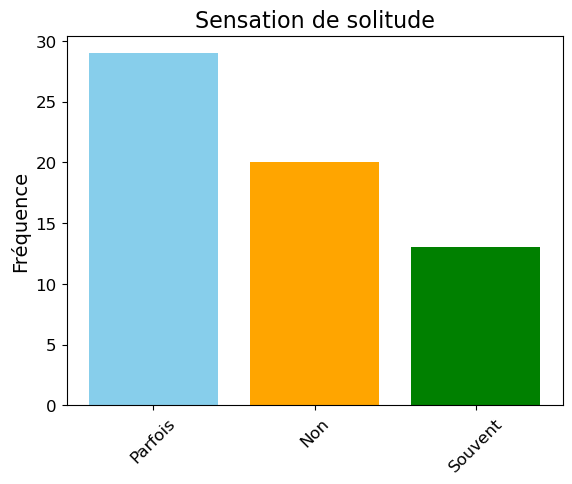

In [28]:
# Solitude

# Calculate frequency of each category
category_counts = data['Solitude'].value_counts()


# Extract categories and their frequencies
Types_Rev = category_counts.index
Rev = category_counts.values

# Create bar plot
plt.bar(Types_Rev, Rev, color=['skyblue', 'orange', 'green', 'red', 'purple'])

# Add labels and title with adjusted font size
plt.ylabel('Fréquence', fontsize=14)
plt.title('Sensation de solitude', fontsize=16)

# Change tick names
plt.xticks(Types_Rev, ['Parfois', 'Non', 'Souvent'], rotation=45)

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()




In [29]:
#



# PCA 

In [30]:
data.columns

Index(['Nationalité', 'Études', 'École', 'Genre', 'Échange', 'Enfants',
       'Dépenses', 'Loyer', 'Revenus', 'Travail', 'Salaire', '2bou', 'Bourses',
       'Budget alimentaire', 'Manger bien et assez', 'Mealprep',
       'Épiceries solidaires', 'Dépenser +', 'Ramen', 'Pk raviolis', 'OALC!',
       'Assurance', 'Maladie', 'Médecin', 'Sport', 'Point santé', 'Pharmacie',
       'Menstruations', 'Santé mentale', 'Avenir', 'Diagnostic',
       'Dispositif aides', 'Famille', 'Études parents',
       'Soutien familiale études', 'Soutien familiale genre',
       'Pression réussite', 'Logement', 'Relation coloc', 'Freq pote',
       'Work buddies', 'Amis ambulance', 'Solitude', 'Revenus_travail',
       'Revenus_bourses_EPFL_UNIL', 'Revenus_bourses_canton',
       'Revenus_bourses_internationales', 'Revenus_famille', 'Revenus_emprunt',
       'SM_heureux', 'SM_satisfait', 'SM_neutre', 'SM_triste', 'SM_stressé',
       'SM_anxieux', 'SM_déprimé', 'PK_ravioli_envie', 'PK_ravioli_temps',
      

In [31]:
# Drop columns
columns_to_drop = ['Revenus', 'Pk raviolis','Sport','Santé mentale']  # List of columns to drop
df = data.drop(columns=columns_to_drop)
df.columns

Index(['Nationalité', 'Études', 'École', 'Genre', 'Échange', 'Enfants',
       'Dépenses', 'Loyer', 'Travail', 'Salaire', '2bou', 'Bourses',
       'Budget alimentaire', 'Manger bien et assez', 'Mealprep',
       'Épiceries solidaires', 'Dépenser +', 'Ramen', 'OALC!', 'Assurance',
       'Maladie', 'Médecin', 'Point santé', 'Pharmacie', 'Menstruations',
       'Avenir', 'Diagnostic', 'Dispositif aides', 'Famille', 'Études parents',
       'Soutien familiale études', 'Soutien familiale genre',
       'Pression réussite', 'Logement', 'Relation coloc', 'Freq pote',
       'Work buddies', 'Amis ambulance', 'Solitude', 'Revenus_travail',
       'Revenus_bourses_EPFL_UNIL', 'Revenus_bourses_canton',
       'Revenus_bourses_internationales', 'Revenus_famille', 'Revenus_emprunt',
       'SM_heureux', 'SM_satisfait', 'SM_neutre', 'SM_triste', 'SM_stressé',
       'SM_anxieux', 'SM_déprimé', 'PK_ravioli_envie', 'PK_ravioli_temps',
       'PK_ravioli_argent', 'PK_ravioli_flemme', 'PK_ravioli_cuis

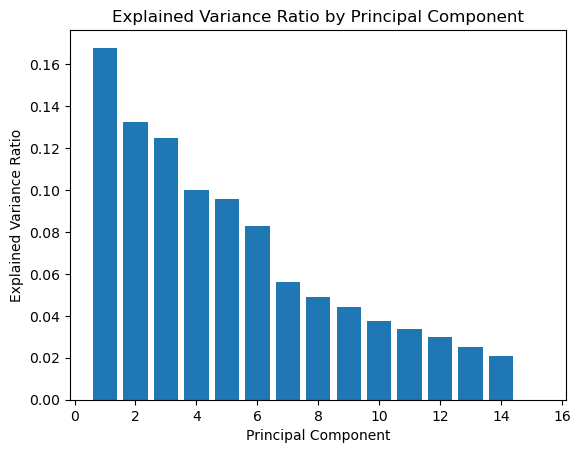

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

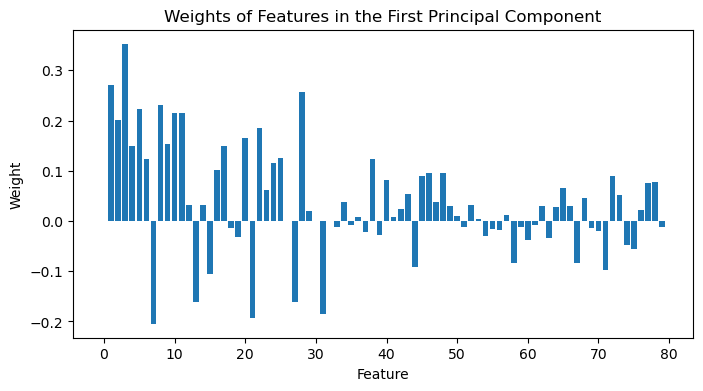

In [32]:
# PCA

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np


df.dropna(inplace=True)


# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

# Preprocessing for numerical data (standardization)
numerical_transformer = StandardScaler()

# Preprocessing for categorical data (one-hot encoding)
categorical_transformer = OneHotEncoder(drop='first')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(df)

# Perform PCA
pca = PCA()
pca.fit(X_preprocessed)

# Get the principal components
components = pca.components_

# Plot explained variance ratio
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

# Plot principal components
plt.figure(figsize=(8, 4))
plt.bar(range(len(components[0])), components[0])  # Plot the first principal component
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Weights of Features in the First Principal Component')
plt.xticks(range(len(components[0])), numerical_cols.tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names()), rotation=45)
plt.show()

# Hypothèses

In [ ]:
# Budget mensuel versus indicateurs de précarité (enlever les personnes qui vivent chez leurs parents)

# Étudiants internationaux  versus indicateurs de précarité


/Users/emiliemonnet/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16')])

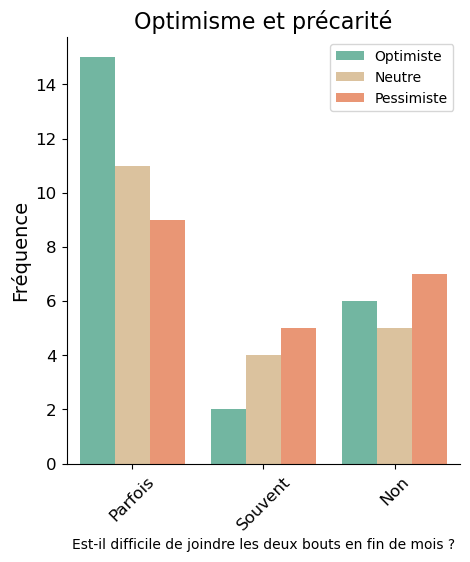

In [ ]:
# Optimisme et joindre les deux bouts
colors=["#66c2a5", "#e5c494","#fc8d62"]
palette = sns.set_palette(sns.color_palette(colors))
#Représentation de 2 catégorical data avec catplot
sns.catplot(data=data, x='2bou', hue = 'Avenir',kind='count',legend=False, palette= palette)
plt.ylabel('Fréquence', fontsize=14)
plt.title('Optimisme et précarité', fontsize=16)

# Change tick names
category_counts = data['2bou'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
plt.xticks(Types_Rev,['Parfois', 'Non', 'Souvent'], rotation=45)
plt.xlabel('Est-il difficile de joindre les deux bouts en fin de mois ?')

#Change label of legend
plt.legend(loc='upper right', labels=['Optimiste', 'Neutre', 'Pessimiste'])

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Normaliser?

/Users/emiliemonnet/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14'),
  Text(0, 16.0, '16')])

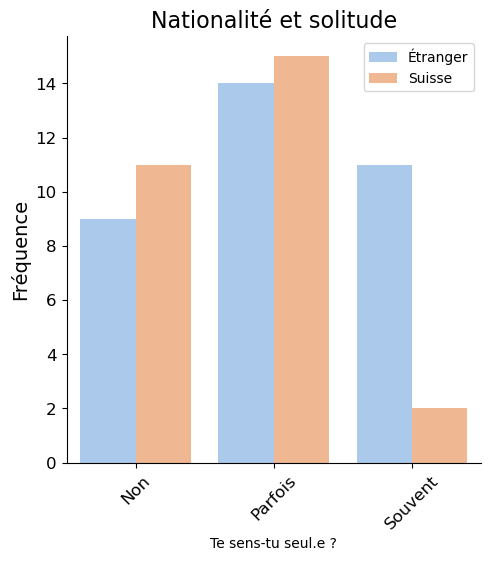

In [59]:
# Solitude / étranger
#Créer colonne suisse ou étranger
data['Étranger'] = data['Nationalité'].apply(lambda x: 'Non' if x == 'Switzerland' else 'Oui' )

#Représentation de 2 catégorical data avec catplot
sns.catplot(data=data, x='Solitude', hue = 'Étranger',kind='count', legend=False, palette= 'pastel')
plt.ylabel('Fréquence', fontsize=14)
plt.title('Nationalité et solitude', fontsize=16)

# Change tick names
category_counts = data['Solitude'].value_counts()
Types_Rev = category_counts.index
Rev = category_counts.values
plt.xticks(Types_Rev,['Parfois', 'Non', 'Souvent'], rotation=45)
plt.xlabel('Te sens-tu seul.e ?')

#Change label of legend
plt.legend(loc='upper right', labels=['Étranger', 'Suisse'])

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_8450/2249307970.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=data, y="Budget alimentaire", x="Manger bien et assez", kind="box", palette='pastel', legend=False)
/Users/emiliemonnet/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/emiliemonnet/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_8450/2249307970.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

Text(0.5, 1.0, 'Budget alimentaire et plats préparés')

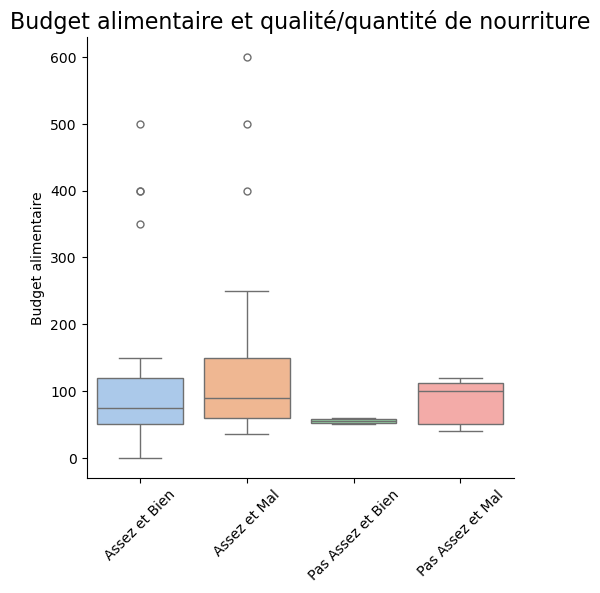

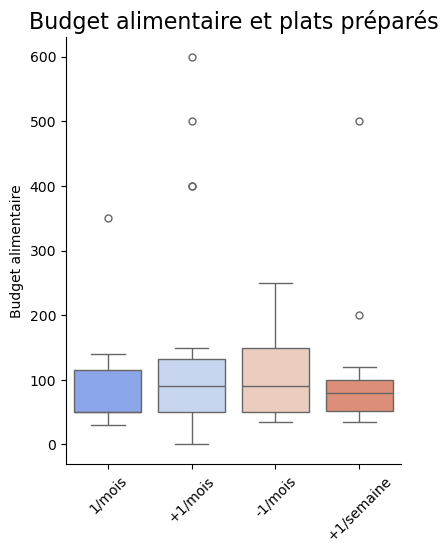

In [ ]:
# Budget alim versus mange bien/ meal prep
sns.catplot(data=data, y="Budget alimentaire", x="Manger bien et assez", kind="box", palette='pastel', legend=False)
category_counts = data['Manger bien et assez'].value_counts()
Types_Rev = category_counts.index
plt.xticks(Types_Rev,['Assez et Bien','Assez et Mal','Pas Assez et Mal','Pas Assez et Bien'], rotation=45)
plt.xlabel(None)
plt.title('Budget alimentaire et qualité/quantité de nourriture', fontsize=16)

sns.catplot(data=data, y="Budget alimentaire", x="Ramen", kind="box", palette='coolwarm', legend=False)
category_counts_2 = data['Ramen'].value_counts()
Types_Rev_2 = category_counts_2.index
plt.xticks(Types_Rev_2,['+1/mois','-1/mois','+1/semaine','1/mois'], rotation=45)
plt.xlabel(None)
plt.title('Budget alimentaire et plats préparés', fontsize=16)

Index(['Plusieurs fois par semaine - Several times a week',
       'Une fois par semaine - Once a week',
       'Plusieurs fois par mois - Several times a month',
       'Moins d'une fois par mois - Less than once a month',
       'Une fois par mois - Once a month'],
      dtype='object', name='Freq pote')


/var/folders/pj/81zyrwwx7vn9lhrcnxq6fn2r0000gn/T/ipykernel_3852/4042199468.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=data, y="Travail", x="Freq pote", kind="box", palette='pastel', legend=False)
/Users/emiliemonnet/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 [Text(0, -2.5, '−2.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0')])

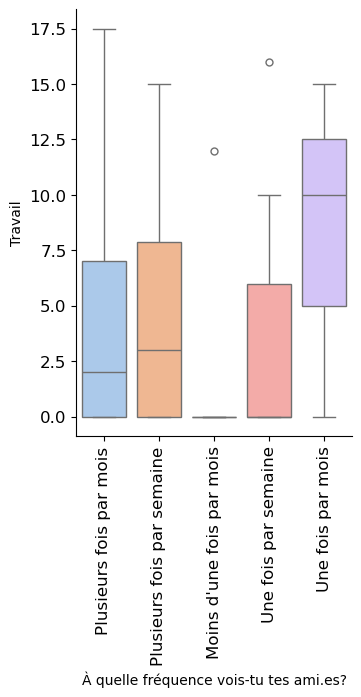

In [46]:
# heures travaillées / fréquence pour voir ses amis

sns.catplot(data=data, y="Travail", x="Freq pote", kind="box", palette='pastel', legend=False)

# Change tick names
category_counts = data['Freq pote'].value_counts()
Types_Rev = category_counts.index
plt.xticks(Types_Rev,['Plusieurs fois par semaine', 'Une fois par semaine', 'Plusieurs fois par mois', "Moins d'une fois par mois", 'Une fois par mois'],rotation=90)
plt.xlabel('À quelle fréquence vois-tu tes ami.es?')

print(Types_Rev)
# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [50]:
# soutien famille et background familial versus santé mentale


/Users/emiliemonnet/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0'),
  Text(0, 22.5, '22.5')])

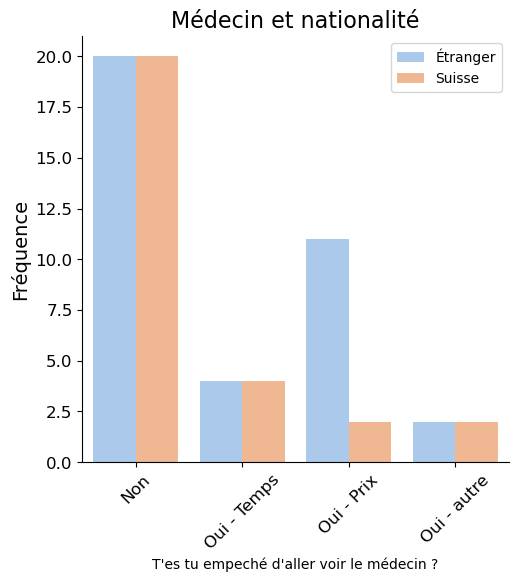

In [65]:
# s'empecher d'aller voir le médecin, étudiants suisses, assurés?
#Représentation de 2 catégorical data avec catplot

sns.catplot(data=data, x='Médecin', hue ='Étranger',kind='count', legend=False, palette= 'pastel',height=5, aspect=7/5)
plt.ylabel('Fréquence', fontsize=14)
plt.title('Médecin et nationalité', fontsize=16)

# Change tick names
category_counts = data['Médecin'].value_counts()
Types_Rev = category_counts.index
plt.xticks(Types_Rev,['Non','Oui - Prix','Oui - Temps','Oui - autre'], rotation=45)
plt.xlabel("T'es tu empeché d'aller voir le médecin ?")

#Change label of legend
plt.legend(loc='upper right', labels=['Étranger', 'Suisse'])

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



/Users/emiliemonnet/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0'),
  Text(0, 22.5, '22.5')])

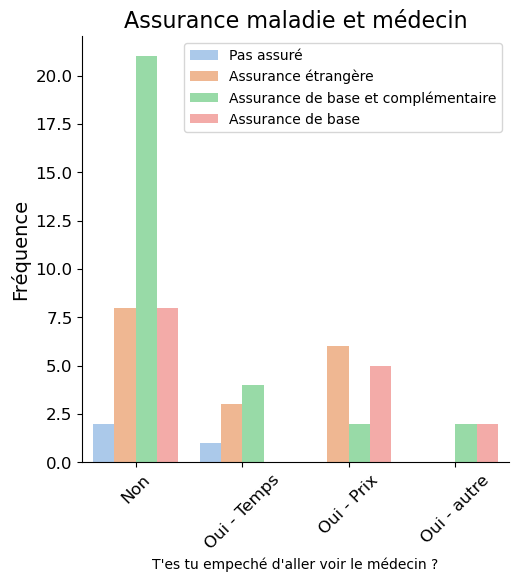

In [71]:
sns.catplot(data=data, x='Médecin', hue ='Assurance',kind='count',legend=False, palette= 'pastel',height=5, aspect=7/5)
plt.ylabel('Fréquence', fontsize=14)
plt.title('Assurance maladie et médecin', fontsize=16)

# Change tick names
category_counts = data['Médecin'].value_counts()
Types_Rev = category_counts.index
plt.xticks(Types_Rev,['Non','Oui - Prix','Oui - Temps','Oui - autre'], rotation=45)
plt.xlabel("T'es tu empeché d'aller voir le médecin ?")

#Change label of legend
plt.legend(loc='upper right', labels=['Pas assuré', 'Assurance étrangère', 'Assurance de base et complémentaire', 'Assurance de base '])

# Adjust tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Connaissance des solutions

In [ ]:
# Bourses 

